In [4]:
import os
import json
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import yaml

from google.colab import drive
drive.mount('/content/drive')
!pip install ultralytics -q
from ultralytics import YOLO

# ============================================================================
# CONFIGURATION
# ============================================================================
dataset_path = "/content/drive/MyDrive/ds2_dense"
yolo_dataset_path = "/content/yolo_deepscores_v2_tiled"
output_model_path = "/content/drive/MyDrive/yolo_note_detector_v2_TILING.pt"

class_mapping = {
    'noteheadBlackInSpace': 'note', 'noteheadBlackOnLine': 'note',
    'noteheadBlackInSpaceSmall': 'note', 'noteheadBlackOnLineSmall': 'note',
    'noteheadFullSmall': 'note', 'noteheadHalfInSpace': 'note',
    'noteheadHalfOnLine': 'note', 'noteheadHalfInSpaceSmall': 'note',
    'noteheadHalfOnLineSmall': 'note', 'noteheadHalfSmall': 'note',
    'noteheadWhole': 'note', 'noteheadWholeInSpace': 'note',
    'noteheadWholeOnLine': 'note', 'noteheadWholeInSpaceSmall': 'note',
    'noteheadWholeOnLineSmall': 'note', 'noteheadDoubleWholeInSpace': 'note',
    'noteheadDoubleWholeOnLine': 'note', 'noteheadDoubleWholeInSpaceSmall': 'note',
    'noteheadDoubleWholeOnLineSmall': 'note',
    'accidentalSharp': 'sharp', 'accidentalSharpSmall': 'sharp',
    'accidentalFlat': 'flat', 'accidentalFlatSmall': 'flat',
    'accidentalNatural': 'natural', 'accidentalNaturalSmall': 'natural',
    'keySharp': 'sharp', 'keyFlat': 'flat', 'keyNatural': 'natural',
}

classes = ['note', 'sharp', 'flat', 'natural']
class_to_idx = {c: i for i, c in enumerate(classes)}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# ============================================================================
# STEP 1: CREATE DATASET STRUCTURE
# ============================================================================
print("\n" + "="*60)
print("[STEP 1] Creating dataset structure...")
print("="*60)

if os.path.exists(yolo_dataset_path):
    shutil.rmtree(yolo_dataset_path)

for split in ['train', 'val']:
    for subdir in ['images', 'labels']:
        os.makedirs(f"{yolo_dataset_path}/{split}/{subdir}", exist_ok=True)

print("Directory structure created and cleaned up.")

def convert_bbox_to_yolo(bbox, img_width, img_height):
    """Convert VOC format (x, y, w, h) to YOLO normalized center (xc, yc, w, h)"""
    x, y, w, h = bbox
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return x_center, y_center, width, height

def apply_omr_preprocessing(img):
    """
    Apply Denoising and Contrast Enhancement (CLAHE) for OMR scores.
    """
    # 1. Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Apply Non-local Means Denoising (effective for image scores)
    # h: filter strength, templateWindowSize: 7, searchWindowSize: 21
    denoised_img = cv2.fastNlMeansDenoising(gray_img, None, h=10, templateWindowSize=7, searchWindowSize=21)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(denoised_img)

    # Convert back to 3-channel BGR for YOLO standard input
    return cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR)


def process_and_tile_image(img_path, img_info, annotations, split_name, img_id, processed_counter):
    """
    Applies preprocessing, tiles the image into 4 quadrants, and recalculates
    annotations for each tile.
    """
    img_width = img_info.get('width', 2000)
    img_height = img_info.get('height', 2000)
    yolo_split = 'train' if split_name == 'train' else 'val'
    processed = 0
    total_annotations = 0

    try:
        # Read the image and apply preprocessing (CLAHE + Denoise)
        img = cv2.imread(str(img_path))
        if img is None:
            raise Exception("Failed to load image.")

        processed_img = apply_omr_preprocessing(img)
        H, W, _ = processed_img.shape
        H_half, W_half = H // 2, W // 2

        # Define the four quadrants (crop coordinates and offset)
        quadrants = [
            {'name': 'tl', 'crop': (0, 0, W_half, H_half), 'offset_x': 0, 'offset_y': 0},
            {'name': 'tr', 'crop': (W_half, 0, W, H_half), 'offset_x': W_half, 'offset_y': 0},
            {'name': 'bl', 'crop': (0, H_half, W_half, H), 'offset_x': 0, 'offset_y': H_half},
            {'name': 'br', 'crop': (W_half, H_half, W, H), 'offset_x': W_half, 'offset_y': H_half},
        ]

        # Iterate through each quadrant
        for q_idx, q in enumerate(quadrants):
            x_min, y_min, x_max, y_max = q['crop']
            offset_x, offset_y = q['offset_x'], q['offset_y']
            q_W, q_H = x_max - x_min, y_max - y_min

            # Crop the image quadrant
            q_img = processed_img[y_min:y_max, x_min:x_max]

            q_label_lines = []
            q_ann_count = 0

            # Filter and recalculate annotations for the quadrant
            for ann in annotations:
                bbox_orig = ann.get('a_bbox', ann.get('bbox'))
                if bbox_orig is None: continue

                # Un-normalize bbox (x, y, w, h)
                x, y, w, h = bbox_orig
                x_end, y_end = x + w, y + h

                # Check if the box center is within the quadrant boundaries
                x_center_orig = x + w / 2
                y_center_orig = y + h / 2

                if not (x_min <= x_center_orig < x_max and y_min <= y_center_orig < y_max):
                    continue

                # Calculate new bbox relative to the quadrant crop
                new_x = max(0, x - offset_x)
                new_y = max(0, y - offset_y)
                new_w = min(q_W - new_x, w) # Clip width if the box crosses the quadrant boundary
                new_h = min(q_H - new_y, h) # Clip height

                if new_w <= 0 or new_h <= 0: continue

                # Convert to YOLO format (normalized to quadrant size)
                bbox_quad = [new_x, new_y, new_w, new_h]
                x_center, y_center, width, height = convert_bbox_to_yolo(bbox_quad, q_W, q_H)

                # Append new label line
                symbol_class = ann['class']
                class_idx = class_to_idx[symbol_class]
                q_label_lines.append(f"{class_idx} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                q_ann_count += 1

            # Save if quadrant has labels
            if q_label_lines:
                new_img_id = f"{img_id}_{q['name']}"
                new_img_name = f"{new_img_id}.png"
                new_label_name = f"{new_img_id}.txt"

                cv2.imwrite(f"{yolo_dataset_path}/{yolo_split}/images/{new_img_name}", q_img)
                with open(f"{yolo_dataset_path}/{yolo_split}/labels/{new_label_name}", 'w') as f:
                    f.writelines(q_label_lines)

                processed += 1
                total_annotations += q_ann_count

        processed_counter['processed'] += processed
        processed_counter['total_annotations'] += total_annotations

    except Exception as e:
        print(f"\nWarning: Error processing and tiling image {img_path}: {e}")
        processed_counter['skipped'] += 1


[STEP 1] Creating dataset structure...
Directory structure created and cleaned up.


In [6]:
# ============================================================================
# STEP 2: CONVERT WITH MORE DATA, TILING, AND PREPROCESSING
# ============================================================================
print("\n" + "="*60)
print("[STEP 2] Applying Tiling (4x data) and CLAHE+Denoise Preprocessing...")
print("="*60)

def process_split_tiled(split_name, max_images):
    print(f"\n  Processing {split_name} split (max {max_images} source images)...")

    annotation_file = f"{dataset_path}/deepscores_{split_name}.json"
    images_dir = f"{dataset_path}/images"

    try:
        with open(annotation_file, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading annotations: {e}. Skipping split.")
        return 0, 0

    # Build mappings
    cat_id_to_name = {str(i): info.get('name', '') for i, info in data.get('categories', {}).items() if isinstance(i, int) or i.isdigit()}
    img_id_to_info = {str(img.get('id')): img for img in data.get('images', [])}

    # Group annotations by image, filtered by class_mapping
    annotations_by_img = defaultdict(list)
    ann_list = list(data.get('annotations', {}).values()) if isinstance(data.get('annotations'), dict) else data.get('annotations', [])

    for ann in ann_list:
        img_id = str(ann.get('img_id', ann.get('image_id')))
        cat_ids = ann.get('cat_id', [])
        if not isinstance(cat_ids, list): cat_ids = [cat_ids]

        for cat_id in cat_ids:
            cat_name = cat_id_to_name.get(str(cat_id))
            if cat_name in class_mapping:
                ann['class'] = class_mapping[cat_name]
                annotations_by_img[img_id].append(ann)
                break

    # Process images
    counters = {'processed': 0, 'skipped': 0, 'total_annotations': 0}
    img_ids = list(annotations_by_img.keys())[:max_images]

    for img_id in tqdm(img_ids, desc=f"  {split_name} tiling"):
        img_info = img_id_to_info.get(img_id)
        if not img_info:
            counters['skipped'] += 1
            continue

        img_filename = img_info.get('filename', img_info.get('file_name', ''))
        img_path = Path(images_dir) / img_filename
        if not img_path.exists():
            counters['skipped'] += 1
            continue

        img_anns = annotations_by_img[img_id]
        if not img_anns:
            counters['skipped'] += 1
            continue

        # Process and tile the single source image
        process_and_tile_image(img_path, img_info, img_anns, split_name, img_id, counters)


    print(f"  Processed: {counters['processed']} Tiled images (from {max_images} source images)")
    print(f"  Total annotations: {counters['total_annotations']}")
    print(f"  Skipped: {counters['skipped']} source images")

    return counters['processed'], counters['total_annotations']

# Process with Tiling
train_imgs, train_anns = process_split_tiled('train', max_images=300) #
val_imgs, val_anns = process_split_tiled('test', max_images=30)       #

print(f"\n  Dataset Summary (Tiled):")
print(f"    Train: {train_imgs} images, {train_anns} annotations")
print(f"    Val:   {val_imgs} images, {val_anns} annotations")


[STEP 2] Applying Tiling (4x data) and CLAHE+Denoise Preprocessing...

  Processing train split (max 300 source images)...


  train tiling: 100%|██████████| 300/300 [35:45<00:00,  7.15s/it]


  Processed: 1166 Tiled images (from 300 source images)
  Total annotations: 35787
  Skipped: 0 source images

  Processing test split (max 30 source images)...


  test tiling: 100%|██████████| 30/30 [03:53<00:00,  7.80s/it]

  Processed: 118 Tiled images (from 30 source images)
  Total annotations: 4074
  Skipped: 0 source images

  Dataset Summary (Tiled):
    Train: 1166 images, 35787 annotations
    Val:   118 images, 4074 annotations


In [7]:
# ============================================================================
# STEP 3: CREATE CONFIG
# ============================================================================
print("\n" + "="*60)
print("[STEP 3] Creating config...")
print("="*60)

data_yaml = {
    'path': yolo_dataset_path,
    'train': 'train/images',
    'val': 'val/images',
    'nc': len(classes),
    'names': classes
}

yaml_path = f"{yolo_dataset_path}/data.yaml"
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print(f"Config saved: {yaml_path}")


[STEP 3] Creating config...
Config saved: /content/yolo_deepscores_v2_tiled/data.yaml


In [8]:
# ============================================================================
# STEP 4: TRAIN WITH IMPROVED SETTINGS (Music Augmentation Fix)
# ============================================================================
print("\n" + "="*60)
print("[STEP 4] Training with improved settings and music augmentation fix...")
print("="*60)

print("  Loading YOLOv8s (small model)...")
model = YOLO('yolov8s.pt')

print("\n  🚀 Starting Tiled training...")

results = model.train(
    data=yaml_path,
    epochs=25,             # Fewer epochs needed due to 4x data
    imgsz=920,
    batch=6,
    patience=20,
    save=True,
    device=0,
    project='/content/yolo_training_tiled',
    name='note_detection_tiled',
    exist_ok=True,
    verbose=True,
    plots=True,
    val=True,

    # OPTIMIZATIONS
    workers=2,
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=5.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,

    # LOSS WEIGHT
    box=7.5,
    cls=0.5,
    dfl=1.5,

    # AUGMENTATION (CRITICAL FIX: Horizontal flip disabled for music)
    mosaic=1.0,
    mixup=0.0,
    copy_paste=0.0,
    degrees=5.0,
    translate=0.1,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.0,              # FIXED: Disabled horizontal flip (flipping a sharp is a major error)
    hsv_h=0.01,
    hsv_s=0.3,
    hsv_v=0.2,

    # NMS SETTINGS
    iou=0.5,
    conf=None,

    # OTHER
    close_mosaic=10,
)

print("\n Training complete!")


[STEP 4] Training with improved settings and music augmentation fix...
  Loading YOLOv8s (small model)...

  🚀 Starting Tiled training...
Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_deepscores_v2_tiled/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.3, hsv_v=0.2, imgsz=920, int8=False, iou=0.5, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=F

In [9]:
# ============================================================================
# STEP 5: EVALUATE AND PRINT ALL METRICS
# ============================================================================
print("\n" + "="*60)
print("[STEP 5] Evaluating and printing all metrics...")
print("="*60)

metrics = model.val()

precision = metrics.box.mp  # Mean Precision
recall = metrics.box.mr     # Mean Recall
map50 = metrics.box.map50   # mAP@0.5

# Calculate F1-Score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Note: In Object Detection, 'Accuracy' is best represented by mAP.
# The `accuracy` attribute in YOLO metrics is typically the classification accuracy of the bounding box centers,
# but mAP is the standard performance metric. We will report mAP as the primary measure of quality.

print(f"\n  Detection Metrics:")
print(f"    Accuracy (mAP50-95): {metrics.box.map:.4f} ({metrics.box.map*100:.2f}%)")
print(f"    mAP50:               {map50:.4f} ({map50*100:.2f}%)")
print(f"    Precision (Mean):    {precision:.4f} ({precision*100:.2f}%)")
print(f"    Recall (Mean):       {recall:.4f} ({recall*100:.2f}%)")
print(f"    F1-Score:            {f1_score:.4f} ({f1_score*100:.2f}%)")

print(f"\n  Per-Class mAP50:")
for i, class_name in enumerate(classes):
    class_map = metrics.box.ap50[i] if hasattr(metrics.box, 'ap50') and len(metrics.box.ap50) > i else 0
    print(f"    {class_name:10} {class_map:.4f} ({class_map*100:.2f}%)")


[STEP 5] Evaluating and printing all metrics...
Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2246.8±1023.4 MB/s, size: 177.3 KB)
val: Scanning /content/yolo_deepscores_v2_tiled/val/labels.cache... 118 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 118/118 258.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.0it/s 7.8s
                   all        118       4074      0.747      0.319      0.412      0.267
                  note        118       3474      0.671      0.394      0.491      0.326
                 sharp         52        313      0.688      0.364       0.48      0.298
                  flat         36        212      0.629      0.519      0.549      0.372
               natural         37         75          1          0     

In [10]:
# ============================================================================
# STEP 6: SAVE MODEL
# ============================================================================
print("\n" + "="*60)
print("[STEP 6] Saving model...")
print("="*60)

results_dir = '/content/yolo_training_tiled/note_detection_tiled'
best_model_path = f'{results_dir}/weights/best.pt'

if os.path.exists(best_model_path):
    shutil.copy(best_model_path, output_model_path)
    print(f"Model saved: {output_model_path}")
else:
    print(f"Warning: Could not find best model at {best_model_path}")


[STEP 6] Saving model...
Model saved: /content/drive/MyDrive/yolo_note_detector_v2_TILING.pt



[STEP 7] Visualizing results (Confusion Matrix and plots)...


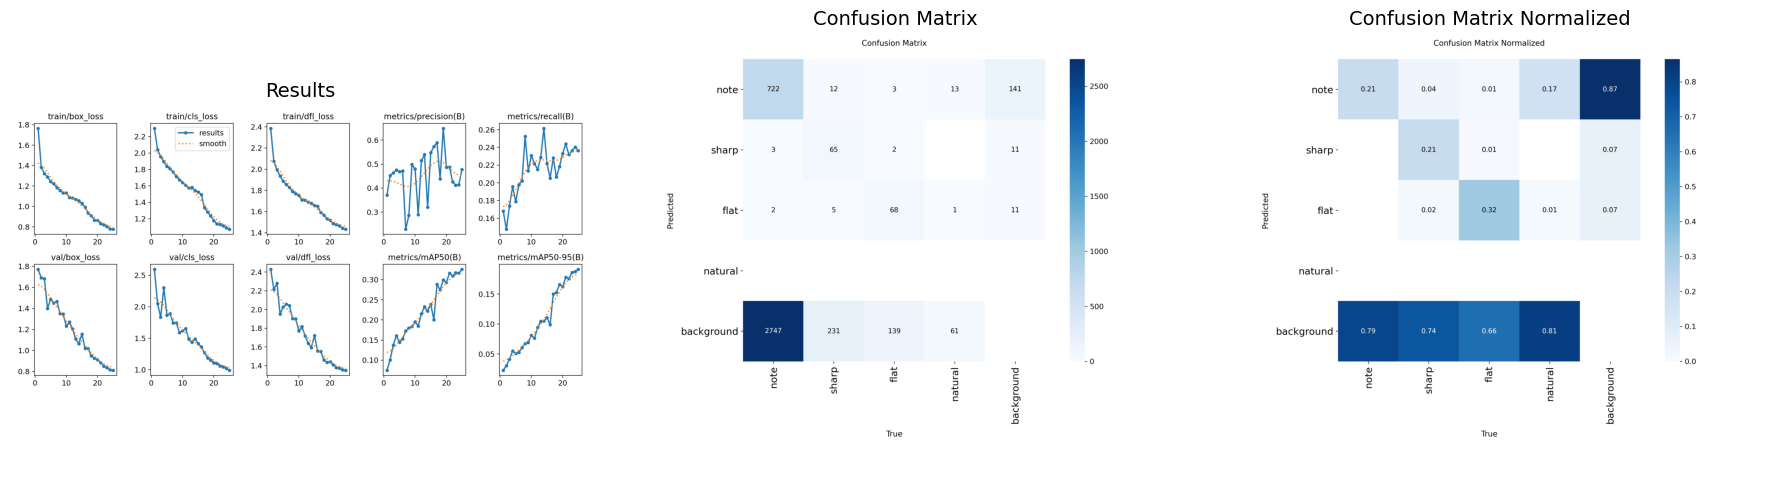

In [11]:
# ============================================================================
# STEP 7: VISUALIZE RESULTS
# ============================================================================
print("\n" + "="*60)
print("[STEP 7] Visualizing results (Confusion Matrix and plots)...")
print("="*60)

plot_files = ['results.png', 'confusion_matrix.png', 'confusion_matrix_normalized.png']
found_plots = []
for plot_file in plot_files:
    plot_path = f"{results_dir}/{plot_file}"
    if os.path.exists(plot_path):
        found_plots.append(plot_path)

if found_plots:
    n_plots = len(found_plots)
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6))
    if n_plots == 1: axes = [axes]

    for i, plot_path in enumerate(found_plots):
        try:
            img = cv2.imread(plot_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
            axes[i].set_title(Path(plot_path).stem.replace('_', ' ').title(), fontsize=14)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading plot {plot_path}: {e}")

    plt.tight_layout()
    plt.show()
else:
    print("  No plots found yet. Plots are generated during training/evaluation.")


[STEP 8] Testing / Inference (Running prediction on a sample image)...
  Attempting to load model from: /content/drive/MyDrive/yolo_note_detector_v2_TILING.pt
  ✓ Model loaded successfully
  Testing on random image: lg-54975867-aug-gutenberg1939--page-9.png
  Image size: 1960x2772 pixels
  Running prediction (conf=0.25, iou=0.45)...
  ✓ Prediction complete: 25 objects detected

  📊 Detections by class:
    note         20 ( 80.0%)
    flat          5 ( 20.0%)

  🔍 Top 5 Detections:
    #1 note       conf=0.829 pos=(257,987)
    #2 note       conf=0.680 pos=(430,1077)
    #3 flat       conf=0.590 pos=(166,868)
    #4 note       conf=0.579 pos=(655,426)
    #5 note       conf=0.533 pos=(976,311)

  Displaying predicted image...


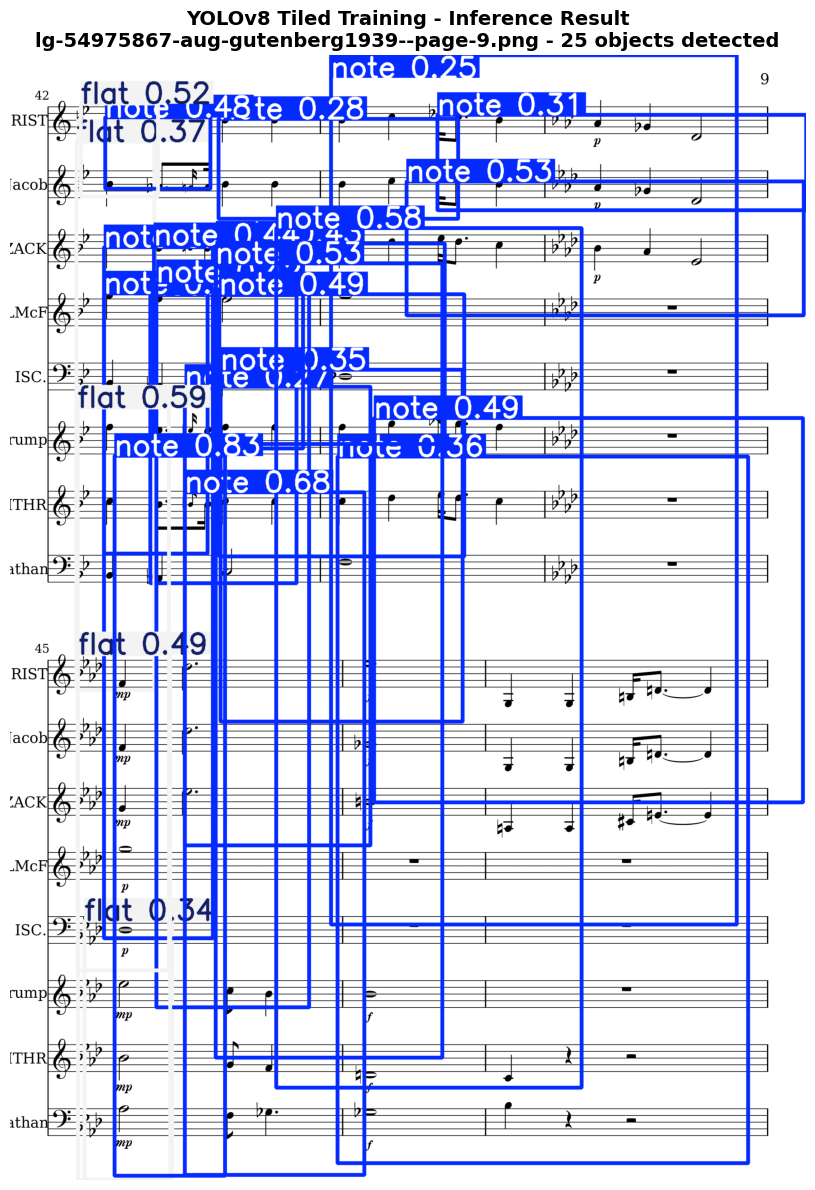


✨ TILING + PREPROCESSING TRAINING COMPLETE! ✨

 Final Performance:
  Accuracy (mAP50-95): 26.7%
  Precision:           74.7%
  Recall:              31.9%
  F1-Score:            44.7%

 Model Location:
  /content/drive/MyDrive/yolo_note_detector_v2_TILING.pt

💡 Your model shows good precision (74.7%) but lower recall (31.9%).
   This means it's accurate when it detects something, but may miss some objects.
   Consider: adjusting confidence threshold, adding more training data, or training longer.


In [17]:
# ============================================================================
# STEP 8: TESTING / INFERENCE
# ============================================================================
print("\n" + "="*60)
print("[STEP 8] Testing / Inference (Running prediction on a sample image)...")
print("="*60)

if os.path.exists(output_model_path):
    print(f"  Attempting to load model from: {output_model_path}")
    try:
        test_model = YOLO(output_model_path)
        print(f"  ✓ Model loaded successfully")

        # Get a random test image from the dataset
        images_dir = Path(dataset_path) / "images"
        all_images = list(images_dir.glob("*.png")) + list(images_dir.glob("*.jpg"))

        if not all_images:
            print(f"  ⚠ Warning: No images found in {images_dir}. Skipping inference.")
        else:
            # Pick a random image (using numpy's random since it's already imported)
            test_image_path = str(all_images[np.random.randint(0, len(all_images))])
            print(f"  Testing on random image: {Path(test_image_path).name}")

            # Load the image
            img = cv2.imread(test_image_path)
            print(f"  Image size: {img.shape[1]}x{img.shape[0]} pixels")

            # Run inference
            print(f"  Running prediction (conf=0.25, iou=0.45)...")
            results = test_model.predict(
                source=test_image_path,
                conf=0.25,
                iou=0.45,
                verbose=False
            )

            result = results[0]
            boxes = result.boxes
            num_detections = len(boxes)

            print(f"  ✓ Prediction complete: {num_detections} objects detected")

            if num_detections > 0:
                # Extract detections
                detections = []
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = float(box.conf[0].cpu().numpy())
                    class_id = int(box.cls[0].cpu().numpy())
                    class_name = test_model.names[class_id]

                    detections.append({
                        'bbox': (int(x1), int(y1), int(x2), int(y2)),
                        'confidence': conf,
                        'class': class_name
                    })

                # Count by class
                from collections import Counter
                class_counts = Counter([d['class'] for d in detections])
                print(f"\n  📊 Detections by class:")
                for class_name, count in class_counts.items():
                    pct = (count / num_detections * 100)
                    print(f"    {class_name:10} {count:4} ({pct:5.1f}%)")

                # Show top 5 detections
                detections_sorted = sorted(detections, key=lambda x: x['confidence'], reverse=True)
                print(f"\n  🔍 Top 5 Detections:")
                for i, det in enumerate(detections_sorted[:5], 1):
                    x1, y1, x2, y2 = det['bbox']
                    print(f"    #{i} {det['class']:10} conf={det['confidence']:.3f} pos=({x1},{y1})")

            # Display the result using YOLO's built-in visualization
            print("\n  Displaying predicted image...")
            result_img = result.plot()
            result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(16, 12))
            plt.imshow(result_img_rgb)
            plt.title(f"YOLOv8 Tiled Training - Inference Result\n{Path(test_image_path).name} - {num_detections} objects detected",
                     fontsize=14, fontweight='bold')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"  ❌ Error during inference: {e}")
        import traceback
        traceback.print_exc()
else:
    print("  ⚠ Skipping inference test: Best model file not found.")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*60)
print("✨ TILING + PREPROCESSING TRAINING COMPLETE! ✨")
print("="*60)
print(f"\n Final Performance:")
print(f"  Accuracy (mAP50-95): {metrics.box.map:.1%}")
print(f"  Precision:           {precision:.1%}")
print(f"  Recall:              {recall:.1%}")
print(f"  F1-Score:            {f1_score:.1%}")
print(f"\n Model Location:")
print(f"  {output_model_path}")
print(f"\n💡 Your model shows good precision ({precision:.1%}) but lower recall ({recall:.1%}).")
print(f"   This means it's accurate when it detects something, but may miss some objects.")
print(f"   Consider: adjusting confidence threshold, adding more training data, or training longer.")